In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))
    
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:2] 
n_proc = 8
rank = 0


In [4]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True
store_on_file = False
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/idies/workspace/scratch"
filename = "ref-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vx,vy,vz = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    #lJHTDB.finalize()
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:2] 
Starting the loading process
Finished loading
Load from disk: 10.15 seconds
vx shape = (128, 1024, 1024)


In [5]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,rank)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate all wavenumbers: 8.26 seconds


In [6]:
%%px 

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

In [64]:
%%px

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

In [90]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial FFT: 24.93 seconds


In [91]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvy=np.complex64(0.0+1.0j)*(ky*cvy)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate vorticity in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate vorticity in k space: 3.21 seconds


In [92]:
%%px 

cvy[kx==(Ny//2)] = 0.

In [93]:
%%px

wy = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [94]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity derivative field in Physical space:
 
wy[:,:,:]=fft.backward3Dfft(cvy,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:2] Calculate 3D spatial inverse FFT: 22.43 seconds


[output:5]

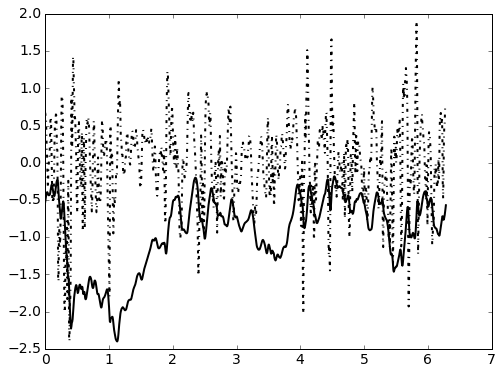

In [95]:
%%px
import numpy as np
import matplotlib.pyplot as plt

if rank==1:
    Y = np.linspace(0, 2*np.pi, Ny, endpoint=True)
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+6.5)   # legend fontsize
    plt.rc('figure', titlesize=SIZE+4)  # size of the figure title
    
    plt.figure(figsize=(8,6))
    lw=2;ms=10
    
    plt.plot(Y[:],vy[0,:,0],'-k',Y[:],wy[0,:,0]/10,'-.k',linewidth=lw,label='dv/dy')
    plt.xlim((2,3))
    plt.show()

In [ ]:
%%px
if(rank==1):
    sk = np.mean(wy**3)/(np.mean(wy**2))**1.5
    print(sk)

[stdout:5] -0.517631177469
